In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.01,
            'metric' : "DP",
            'lambda': 1.0,
            'lambda_old': 0.0,
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=0_epoch=15_lr=0.001_tau=10.0_alpha=0.01_lmbd_1.0_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [7]:
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector

from algorithms import SensitiveAlgorithm
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])

algorithm = SensitiveAlgorithm(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8271127393688753, 'loss': 0.002176862856456856, 'std': 0.04737705654949209, 'EER': -1, 'EO': [0.4595588235294118, 0.25], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6452205882352942, 'classwise_accuracy': {1: array([ 885, 1135]), 0: array([857, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 591, 0: 488}, 'class_pred_count_s1': {1: 417, 0: 619}, 'class_pred_count': {1: 1008, 0: 1107}, 'count_s0': 1079, 'count_s1': 1036, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9061584105007642, 'loss': 0.0011422632222479962, 'std': 0.016290569091072515, 'EER': -1, 'EO': [0.1544715447154471, 0.22977941176470584], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8078745217599235, 'classwise_accuracy': {0: array([904, 980]), 1: array([1010, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 488, 1: 591}, 'class_pred_count_s1': {1: 495, 0: 541}, 'class_pred_count': {0: 1

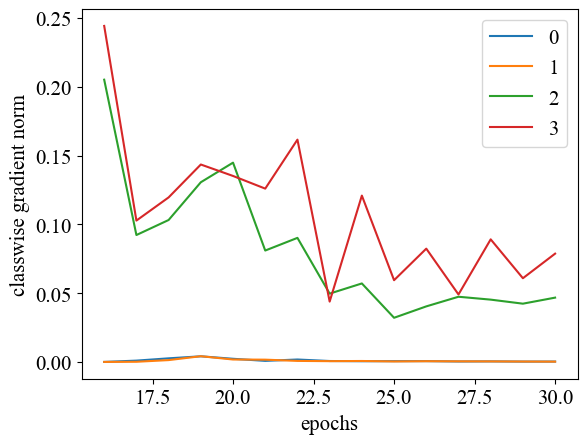

---------------------------- Task 3 -----------------------
Elapsed time(grad):5.358
losses=tensor([[5.2001e-04, 5.4801e-04, 2.2311e-01, 2.3376e-01, 1.0412e+01, 1.0279e+01,
         6.2625e-03, 1.0639e-02, 5.2281e-01, 2.8607e-01, 1.0382e+01, 1.1340e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):12.938
Fairness:[-7.75566278e-04  0.00000000e+00  9.10399354e-04  5.42101086e-20
  0.00000000e+00  1.07211993e-02]
Current class expected loss:[0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=2432
[31] Eval metrics for task 1 >> {'accuracy': 0.9177470106985526, 'loss': 0.001137293315102868, 'std': 0.03203272498426685, 'EER': -1, 'EO': [0.18682526989204318, 0.09771884642181738], 'DP': -1, 'accuracy_s0': 0.9880620509833291, 'accuracy_s1': 0.8457899928263989, 'classwise_accuracy': {0: array([868, 980]), 1: array([1078, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {1: 589, 0: 478, 2: 1, 3: 3, 5: 8}, 'class_pred_count_s1': {0: 390, 1: 489, 2: 66, 3: 44, 5: 20, 4:

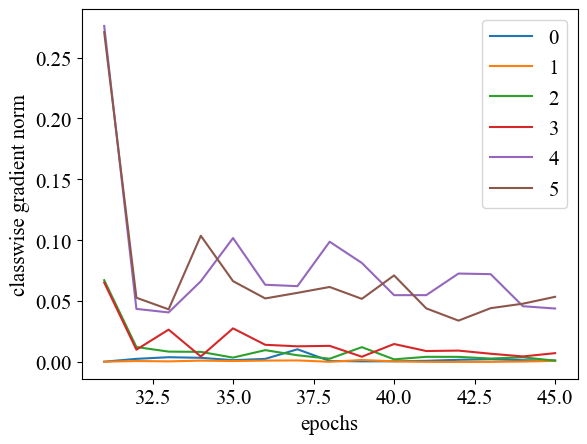

---------------------------- Task 4 -----------------------
Elapsed time(grad):5.723
losses=tensor([[2.5004e-03, 4.2878e-04, 6.8270e-03, 1.6311e-02, 6.0650e-01, 2.0674e-01,
         1.1812e+01, 7.2543e+00, 9.3121e-03, 2.3409e-02, 2.7478e-02, 2.9209e-02,
         4.0490e-01, 1.1792e+00, 1.0679e+01, 1.0019e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):19.893
Fairness:[ 0.00014282  0.         -0.0043288   0.00099544  0.00141069  0.007948
  0.          0.01794152]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=2304
[46] Eval metrics for task 1 >> {'accuracy': 0.9033219455182955, 'loss': 0.0013825767358707762, 'std': 0.04821990470196885, 'EER': -1, 'EO': [0.09051209316213793, 0.15800346528055453], 'DP': -1, 'accuracy_s0': 0.9646750436881085, 'accuracy_s1': 0.8404172644667622, 'classwise_accuracy': {1: array([1080, 1135]), 0: array([838, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 588, 0: 456, 5: 32, 3: 1, 6: 1, 4

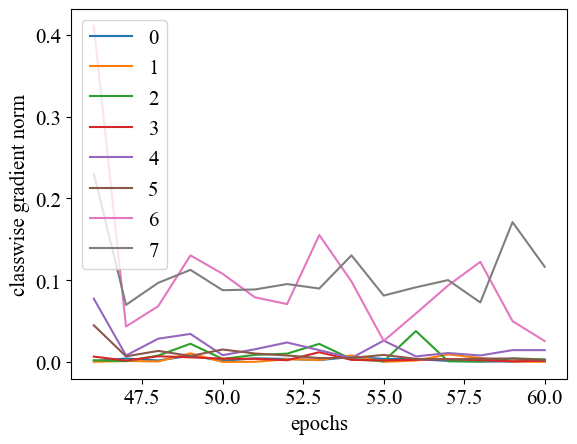

---------------------------- Task 5 -----------------------
Elapsed time(grad):5.392
losses=tensor([[4.2768e-02, 1.2971e-03, 3.1064e-04, 4.3857e-03, 1.7861e-02, 1.7111e-02,
         3.7772e-01, 2.7616e-01, 9.5087e+00, 1.1954e+01, 5.7694e-01, 1.6933e-01,
         6.2465e-03, 3.4023e-02, 1.7424e-01, 4.9704e-01, 1.4523e+00, 8.3992e-01,
         1.0160e+01, 1.0793e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):20.859
Fairness:[ 0.00000000e+00  1.08420217e-19 -5.13035557e-04  0.00000000e+00
  6.44856572e-05  1.85090826e-03  5.58588996e-03  0.00000000e+00
  2.95538199e-03 -4.80169700e-03]
Current class expected loss:[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -8.8817842e-16]
len(updated_seq_indices)=2688
[61] Eval metrics for task 1 >> {'accuracy': 0.8731052773532321, 'loss': 0.002500319480895996, 'std': 0.06698282837364022, 'EER': -1, 'EO': [0.09322745595700199, 

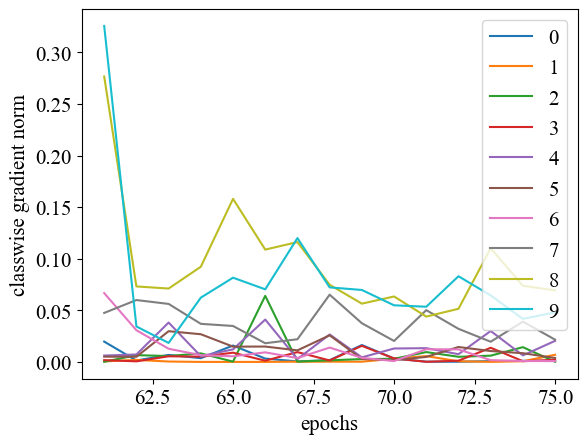

final avg-acc 0.8316834540152296
final avg-forget 0.06550668037712487


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [13]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.997, 0.   , 0.   , 0.   , 0.   ],
       [0.955, 0.912, 0.   , 0.   , 0.   ],
       [0.937, 0.873, 0.754, 0.   , 0.   ],
       [0.825, 0.878, 0.816, 0.793, 0.   ],
       [0.882, 0.777, 0.804, 0.873, 0.823]])

In [14]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.8888696420069427

In [15]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.007, 0.08, 0.181, 0.252, 0.204]

In [16]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.1448209357464732

In [17]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.011, 0.01, 0.015, 0.015, 0.007]

In [18]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.011639970376797643